In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from matplotlib import pyplot as plt
from matplotlib import image as img
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.ensemble import GradientBoostingRegressor

In [13]:
train_df = pd.read_csv('./train.csv', sep=',')
test_df = pd.read_csv('./test.csv', sep=',')

In [14]:
class Data:
    
    def __init__(self):
        self.Price = None
        self.medians = None
        self.mode_Rooms = None
        self.mode_HouseFloor = None
        self.mode_Floor = None
        self.mode_Social_1 = None
        self.mode_Healthcare_2 = None
        self.mode_Shops_1 = None
        
    def reduce_mem_usage(self, df):
    
        for col in df.columns:
            col_type = df[col].dtype
            if col_type != object:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
            else:
                df[col] = df[col].astype('category')
        return df

    
    def new_fiew(self, df):
        df = df.astype({'HouseFloor': np.int8, 
                        'Rooms': np.int8, 
                        'Social_2': np.float32, 
                        'Social_3': np.float32
                       })
        df.rename(columns = {'DistrictId' : 'District', 
                             'HouseYear' : 'Year', 
                             'Helthcare_2' : 'Healthcare_2'}, 
                  inplace = True)
        return df
    
        
    def fit(self, df):
        self.Price = df['Price']
        self.medians = df.median()
        self.mode_Rooms = df['Rooms'].mode()[0]
        self.mode_HouseFloor = df['HouseFloor'].mode()[0]
        self.mode_Floor = df['Floor'].mode()[0]
        self.mode_Social_1 = df['Social_1'].mode()[0]
        self.mode_Healthcare_2 = df['Healthcare_2'].mode()[0]
        self.mode_Shops_1 = df['Shops_1'].mode()[0]
        return df
        
        
    def transform(self, df):
        df.loc[(df['Rooms'] > 6) | (df['Rooms'] < 1), 'Rooms'] = self.mode_Rooms
        df.loc[(df['Square'] > 300) | (df['Square'] < 15), 'Square'] = self.medians.Square
        df.loc[(df['KitchenSquare'] > 30) | (df['KitchenSquare'] < 3), 'KitchenSquare'] = self.medians.KitchenSquare
        df.loc[(df['LifeSquare'] > 280) | (df['LifeSquare'] < 10), 'LifeSquare'] = self.medians.LifeSquare
        df.loc[(df['HouseFloor'] > 50) | (df['HouseFloor'] < 1), 'HouseFloor'] = self.mode_HouseFloor
        df.loc[(df['Floor'] > 50) | (df['Floor'] < 1), 'Floor'] = self.mode_Floor
        df.loc[df['Year'] > 2020, 'Year'] = 2020
        df.loc[df['Ecology_1'] == 0, 'Ecology_1'] = self.medians.Ecology_1
        df.loc[df['Social_3'] == 0, 'Social_3'] = self.mode_Floor
        df.loc[df['Social_1'] == 0, 'Social_1'] = self.mode_Social_1
        df.loc[df['Healthcare_2'] == 0, 'Healthcare_2'] = self.mode_Healthcare_2
        df.loc[df['Shops_1'] == 0, 'Shops_1'] = self.mode_Shops_1
        return df
    
    
    def new_features(self, df):
        df['Floor_altitude'] = (df['Floor'] / df['HouseFloor']).round(decimals=1)
        df.loc[df['Floor_altitude'] > 1, 'Floor_altitude'] = df['Floor_altitude'].median()
        df['IsFirstFloor'] = (df['Floor_altitude'] < 0.2).astype(int)
        
        df['LifeSquare_fraction'] = (1 - df['KitchenSquare'] / df['Square']).round(decimals=3)
        df.loc[df['LifeSquare_fraction'] < 0.7, 'LifeSquare_fraction'] = df['LifeSquare_fraction'].median()
        df['LifeSquare_new'] = df['LifeSquare_fraction'] * df['Square']
        df.loc[df['LifeSquare'] == df['LifeSquare'].median(), 'LifeSquare'] = df['LifeSquare_new']
        df.loc[(df['LifeSquare'].isna()), 'LifeSquare'] = df['LifeSquare_new']
        
        df['Price_per_square'] = self.Price / df['Square'].round(decimals=3)
        df_mean_price_dist = df.groupby('District').median()['Price_per_square'].round()
        df_mean = pd.DataFrame(df_mean_price_dist)
        df_mean.rename(columns = {'Price_per_square' : 'Median_Price_per_square'}, inplace = True)
        df = df.merge(df_mean, on=['District'])
        
        df['Year_expensive'] = 0
        df.loc[df['Year'] <= 1955, 'Year_expensive'] = 10
        df.loc[(df['Year'] > 1995) & (df['Year'] <= 2005), 'Year_expensive'] = 9
        df.loc[(df['Year'] > 1985) & (df['Year'] <= 1995), 'Year_expensive'] = 8
        df.loc[(df['Year'] > 1977) & (df['Year'] <= 1985), 'Year_expensive'] = 7
        df.loc[df['Year'] == 1976, 'Year_expensive'] = 7
        df.loc[(df['Year'] > 1955) & (df['Year'] <= 1965), 'Year_expensive'] = 6
        df.loc[(df['Year'] > 2005) & (df['Year'] <= 2015), 'Year_expensive'] = 5
        df.loc[(df['Year'] > 1970) & (df['Year'] <= 1975), 'Year_expensive'] = 4
        df.loc[df['Year'] > 2015, 'Year_expensive'] = 3
        df.loc[(df['Year'] > 1965) & (df['Year'] <= 1970), 'Year_expensive'] = 2
        df.loc[df['Year'] == 1977, 'Year_expensive'] = 1
        
        df.replace({'Ecology_2': {'A': 0, 'B': 1}}, inplace=True)
        df.replace({'Ecology_3': {'A': 0, 'B': 1}}, inplace=True)
        df.replace({'Shops_2': {'A': 0, 'B': 1}}, inplace=True)

        df.drop(['District', 'Healthcare_1', 
                 'HouseFloor', 'Floor', 'Id', 
                 'Price_per_square', 'Year',
                 'LifeSquare_new', 'LifeSquare_fraction'], inplace=True, axis=1)
        return df
    
    def scaler(self, df):
        mms = MinMaxScaler()
        feature_names_for_norm = df[['Ecology_1','Social_1', 'Social_2', 'Social_3', 
                                     'Healthcare_2', 'Shops_1', 'Year_expensive']].columns.tolist()
        mms.fit(df[feature_names_for_norm])
        norm_features_df = mms.transform(df[feature_names_for_norm])
        df[feature_names_for_norm] = norm_features_df
        return df

In [15]:
preprocessor = Data()

train_df = preprocessor.reduce_mem_usage(train_df)
test_df = preprocessor.reduce_mem_usage(test_df)

train_df = preprocessor.new_fiew(train_df)
test_df = preprocessor.new_fiew(test_df)

preprocessor.fit(train_df)

train_df = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)

train_df = preprocessor.new_features(train_df)
test_df = preprocessor.new_features(test_df)

train_df = preprocessor.scaler(train_df)
test_df = preprocessor.scaler(test_df)

In [16]:
X = train_df.drop(columns='Price')
y = train_df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=100)

In [17]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(12, 10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.plot([0, 650000], [0, 650000], linestyle='--', color='black')
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.plot([0, 650000], [0, 650000], linestyle='--', color='black')
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [18]:
final_model = GradientBoostingRegressor(criterion='mse',
                                        max_depth=5,
                                        min_samples_leaf=4,
                                        min_samples_split=6,
                                        random_state=42,
                                        n_estimators=170)

final_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=5, min_samples_leaf=4,
                          min_samples_split=6, n_estimators=170,
                          random_state=42)

Train R2:	0.886
Test R2:	0.745


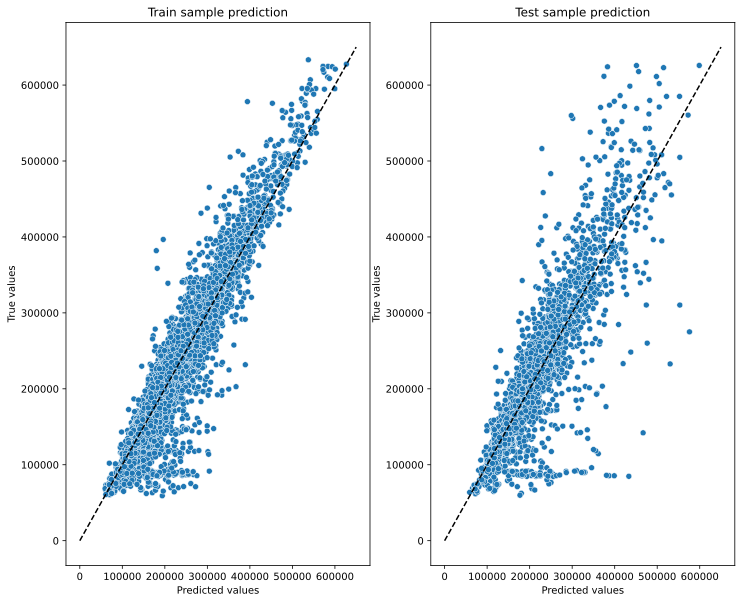

In [19]:
y_train_preds = final_model.predict(X_train)
y_test_preds = final_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

In [20]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances.head()

,feature_name,importance
1,Square,0.479421
15,Median_Price_per_square,0.363500
2,LifeSquare,0.027853
16,Year_expensive,0.025245
0,Rooms,0.024224


In [21]:
submit = pd.read_csv('./sample_submission.csv', sep=',')
predictions = final_model.predict(test_df)
submit['Price'] = predictions
# submit.to_csv('submit.csv', index=False)

In [22]:
submit.head()

,Id,Price
0,4567,168932.239833
1,5925,246354.853553
2,960,187337.195353
3,3848,201539.511133
4,746,200690.977963
